# Import modules

In [1]:

import torch
import torch.optim as optim
from tensordict import TensorDict
import matplotlib.pyplot as plt
from models.autoencoder import KoopmanAutoencoder
from models.utils import load_checkpoint, load_config, get_dataset_class_and_kwargs, load_datasets
from models.dataloader import create_dataloaders
from models.metrics import Metric
from models.cnn import TransformerConfig


# Configuration


In [2]:
CONFIG_PATH = "/home/rg625/mnt/ocean_forecasting/koopman_autoencoder/configs/model/128_inc.yaml"  # Update this path
CKPT_PATH = '/home/rg625/mnt/ocean_forecasting/koopman_autoencoder/model_outputs/128_inc_kl_0.1/best_model.pth'  # Set to specific checkpoint if needed, otherwise loads best/final

ROLL_OUT_STEPS = 40  # Number of future time steps to predict
VISUALIZE = True     # Toggle to show visualizations
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
config = load_config(CONFIG_PATH)
config['training']['use_checkpoint'] = False  # Don't checkpoint during testing

dataset_class, dataset_kwargs = get_dataset_class_and_kwargs(config)
train_dataset, val_dataset, test_dataset = load_datasets(config, dataset_class, dataset_kwargs)
_, _, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    config=config
)

self.means.items(): dict_items([('p', tensor(0.0005)), ('v_x', tensor(0.4420)), ('v_y', tensor(-5.5162e-05))])
self.stds.items(): dict_items([('p', tensor(0.0046)), ('v_x', tensor(0.2186)), ('v_y', tensor(0.1758))])
self.means.items(): dict_items([('p', tensor(0.0001)), ('v_x', tensor(0.4396)), ('v_y', tensor(-3.7312e-05))])
self.stds.items(): dict_items([('p', tensor(0.0043)), ('v_x', tensor(0.2236)), ('v_y', tensor(0.1475))])
self.means.items(): dict_items([('p', tensor(0.0002)), ('v_x', tensor(0.4333)), ('v_y', tensor(-0.0001))])
self.stds.items(): dict_items([('p', tensor(0.0043)), ('v_x', tensor(0.2289)), ('v_y', tensor(0.1162))])


#  Load Model 


In [4]:
model = KoopmanAutoencoder(
    input_frames=config["data"]["input_sequence_length"],
    input_channels=config["model"]["input_channels"],
    height=config["model"]["height"],
    width=config["model"]["width"],
    latent_dim=config["model"]["latent_dim"],
    hidden_dims=config["model"]["hidden_dims"],
    use_checkpoint=config["training"]["use_checkpoint"],
    transformer_config=TransformerConfig(**config["model"]["transformer"]),
    predict_re=config["model"]["predict_re"],
    **config["model"]["conv_kwargs"],
).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config["lr_scheduler"]["lr"])

if CKPT_PATH is not None:
    print(f"Loading from checkpoint: {CKPT_PATH}")
    model, _, _, _ = load_checkpoint(CKPT_PATH, model=model, optimizer=optimizer)

model.eval()

Loading from checkpoint: /home/rg625/mnt/ocean_forecasting/koopman_autoencoder/model_outputs/128_inc_kl_0.1/best_model.pth


RuntimeError: Error(s) in loading state_dict for KoopmanAutoencoder:
	Missing key(s) in state_dict: "history_encoder.transformer.layers.0.self_attn.in_proj_weight", "history_encoder.transformer.layers.0.self_attn.in_proj_bias", "history_encoder.transformer.layers.0.self_attn.out_proj.weight", "history_encoder.transformer.layers.0.self_attn.out_proj.bias", "history_encoder.transformer.layers.0.linear1.weight", "history_encoder.transformer.layers.0.linear1.bias", "history_encoder.transformer.layers.0.linear2.weight", "history_encoder.transformer.layers.0.linear2.bias", "history_encoder.transformer.layers.0.norm1.weight", "history_encoder.transformer.layers.0.norm1.bias", "history_encoder.transformer.layers.0.norm2.weight", "history_encoder.transformer.layers.0.norm2.bias", "history_encoder.transformer.layers.1.self_attn.in_proj_weight", "history_encoder.transformer.layers.1.self_attn.in_proj_bias", "history_encoder.transformer.layers.1.self_attn.out_proj.weight", "history_encoder.transformer.layers.1.self_attn.out_proj.bias", "history_encoder.transformer.layers.1.linear1.weight", "history_encoder.transformer.layers.1.linear1.bias", "history_encoder.transformer.layers.1.linear2.weight", "history_encoder.transformer.layers.1.linear2.bias", "history_encoder.transformer.layers.1.norm1.weight", "history_encoder.transformer.layers.1.norm1.bias", "history_encoder.transformer.layers.1.norm2.weight", "history_encoder.transformer.layers.1.norm2.bias", "history_encoder.transformer.layers.2.self_attn.in_proj_weight", "history_encoder.transformer.layers.2.self_attn.in_proj_bias", "history_encoder.transformer.layers.2.self_attn.out_proj.weight", "history_encoder.transformer.layers.2.self_attn.out_proj.bias", "history_encoder.transformer.layers.2.linear1.weight", "history_encoder.transformer.layers.2.linear1.bias", "history_encoder.transformer.layers.2.linear2.weight", "history_encoder.transformer.layers.2.linear2.bias", "history_encoder.transformer.layers.2.norm1.weight", "history_encoder.transformer.layers.2.norm1.bias", "history_encoder.transformer.layers.2.norm2.weight", "history_encoder.transformer.layers.2.norm2.bias", "history_encoder.transformer.layers.3.self_attn.in_proj_weight", "history_encoder.transformer.layers.3.self_attn.in_proj_bias", "history_encoder.transformer.layers.3.self_attn.out_proj.weight", "history_encoder.transformer.layers.3.self_attn.out_proj.bias", "history_encoder.transformer.layers.3.linear1.weight", "history_encoder.transformer.layers.3.linear1.bias", "history_encoder.transformer.layers.3.linear2.weight", "history_encoder.transformer.layers.3.linear2.bias", "history_encoder.transformer.layers.3.norm1.weight", "history_encoder.transformer.layers.3.norm1.bias", "history_encoder.transformer.layers.3.norm2.weight", "history_encoder.transformer.layers.3.norm2.bias", "re.re.0.weight", "re.re.0.bias", "re.re.2.weight", "re.re.2.bias". 
	size mismatch for history_encoder.layers.0.stack.0.weight: copying a param with shape torch.Size([64, 57, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 3, 3]).

#  Run Rollout


In [5]:
def run_long_rollout(model, input_seq, rollout_steps):
    input_seq = input_seq.unsqueeze(0).to(DEVICE)  # [1, T, C, H, W]

    with torch.no_grad():
        out = model(input_seq, seq_length=rollout_steps)

    return out.x_preds.cpu()  # [T+rollout_steps, C, H, W]

#  Visualize


In [ ]:
input_seq, ground_truth = test_dataset.__getitem__((0, ROLL_OUT_STEPS))  # [T, C, H, W]

predicted_seq = run_long_rollout(model, input_seq, ROLL_OUT_STEPS)
print(predicted_seq)

TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 40, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([1, 40, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([1, 40, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([1]),
    device=cpu,
    is_shared=False)


#  Plot Results 


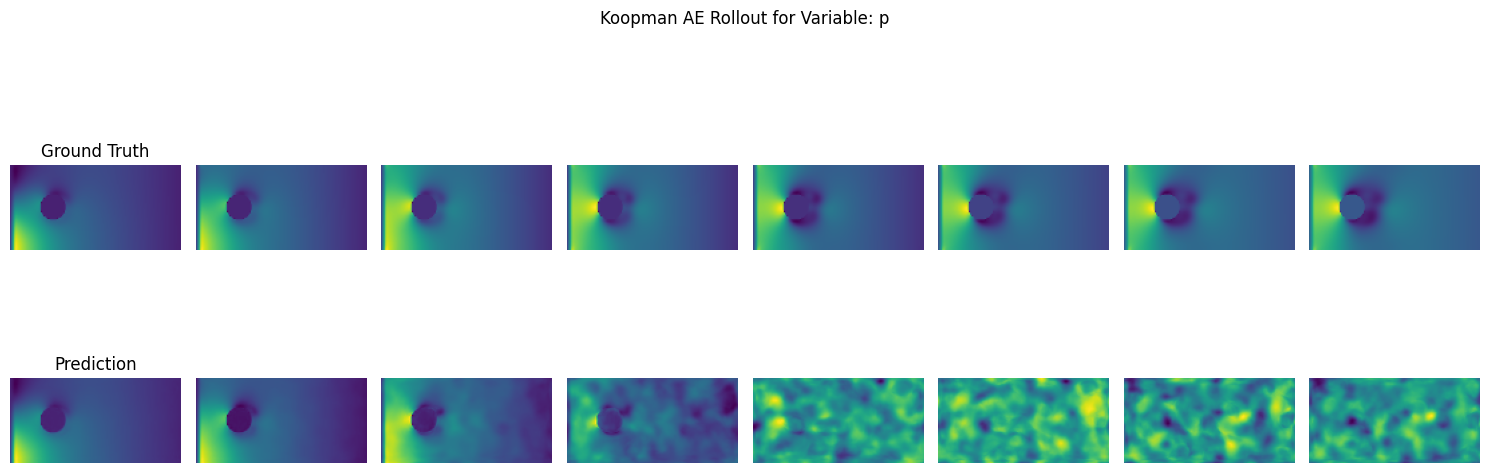

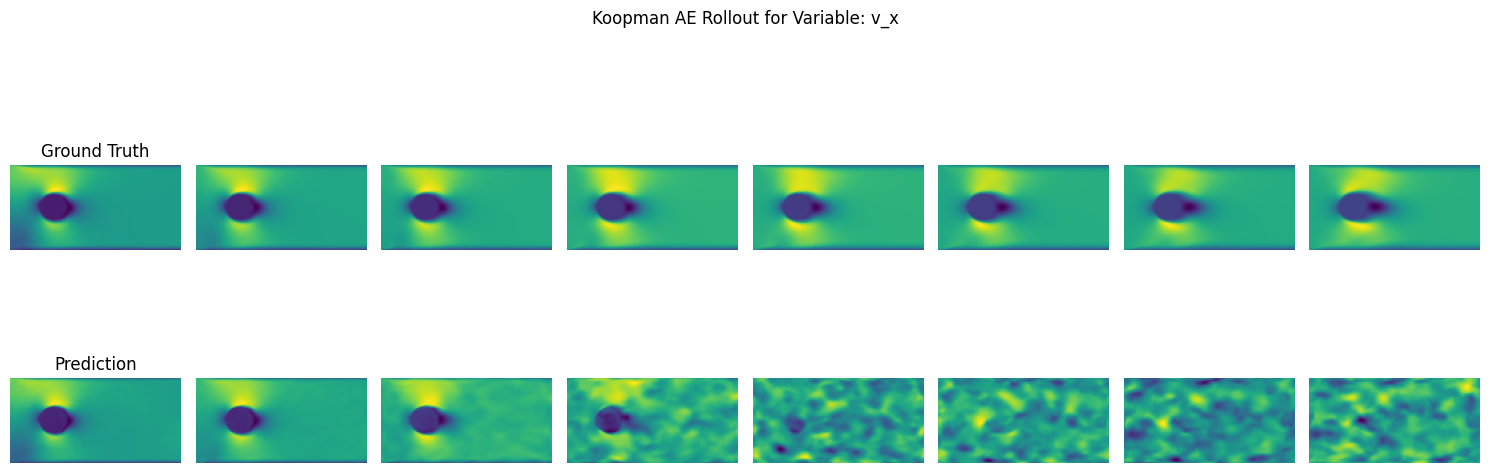

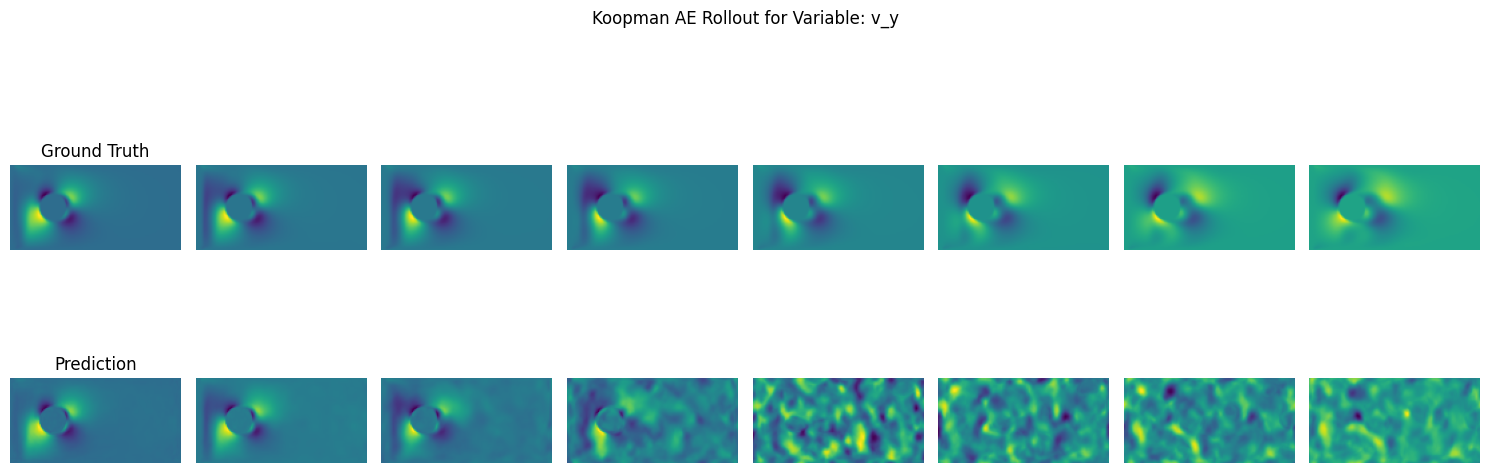

In [7]:
def plot_rollout(gt_dict, pred_dict, variable_name, frame_stride=5):
    """
    Plots the rollout comparison between ground truth and predicted sequence for a given variable.
    
    Args:
        gt_dict (TensorDict): TensorDict of ground truth tensors [T, H, W] per variable.
        pred_dict (TensorDict): TensorDict of predicted tensors [T, H, W] per variable.
        variable_name (str): The key for the variable to visualize.
        frame_stride (int): Step between frames to plot.
    """
    if gt_dict.batch_dims == 1 and gt_dict.batch_size[0] == 1:
        gt_dict = gt_dict.squeeze(0)
    if pred_dict.batch_dims == 1 and pred_dict.batch_size[0] == 1:
        pred_dict = pred_dict.squeeze(0)
    gt = gt_dict[variable_name]  # shape: [T, H, W]
    pred = pred_dict[variable_name]  # shape: [T, H, W]

    num_frames = min(gt.shape[0], pred.shape[0])
    indices = list(range(0, num_frames, frame_stride))
    num_plots = min(len(indices), 10)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices[:num_plots]):
        plt.subplot(2, num_plots, i + 1)
        plt.imshow(gt[idx].cpu(), cmap='viridis')
        plt.axis('off')
        if i == 0:
            plt.title("Ground Truth")

        plt.subplot(2, num_plots, num_plots + i + 1)
        plt.imshow(pred[idx].cpu(), cmap='viridis')
        plt.axis('off')
        if i == 0:
            plt.title("Prediction")

    plt.suptitle(f"Koopman AE Rollout for Variable: {variable_name}")
    plt.tight_layout()
    plt.show()

if VISUALIZE:
    plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="p")    
    plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="v_x")
    plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="v_y")

# Metrics

TensorDict(
    fields={
        Re: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        p: Tensor(shape=torch.Size([40, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        seq_length: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        v_x: Tensor(shape=torch.Size([40, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([40, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)
TensorDict(
    fields={
        p: Tensor(shape=torch.Size([40, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([40, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([40, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


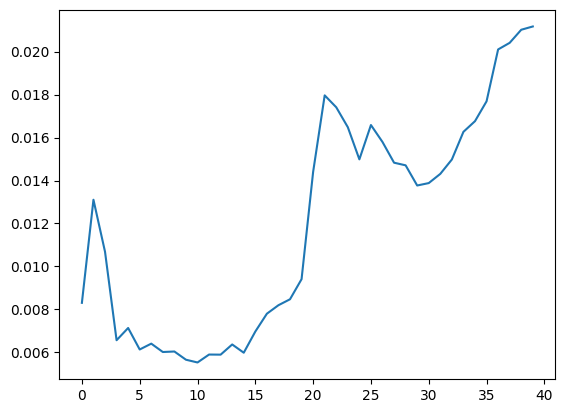

In [8]:
metric = Metric(
    mode=config["metric"]["type"],
    variable_mode=config["metric"]["variable_mode"]
)
target_denorm = test_loader.denormalize(ground_truth)
preds_denorm = test_loader.denormalize(predicted_seq.squeeze())

# Map both to [0, 1] using dataset min/max
target_unit = test_loader.to_unit_range(target_denorm)
preds_unit = test_loader.to_unit_range(preds_denorm)
print(target_unit)
print(preds_unit)
ipt = TensorDict(
    {
    "reference": target_unit,
    "other": preds_unit, 
    }
)
loss = metric(ipt)
print(f"\nLong Rollout {config['metric']['type']} Metric: {loss.mean().item():.4f}")
plt.plot(loss.squeeze().cpu().detach().numpy())
plt.show()